# Model HALVES
## Compares periods of learning and nonlearning between early (run1) and late (run2)

In [71]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
from os.path import join, split
import numpy as np
import pandas as pd
from scipy import stats
from glob import glob
import seaborn as sns
sns.set_palette('muted')
sns.set_style("white")

#subs = ['WMAZE_001']

subs = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

sets = ['set1', 'set2', 'set3']

counts = {'first_learn':[], 'second_learn':[], 'first_nonlearn':[], 'second_nonlearn':[]}
avgs = {'first_learn':[], 'second_learn':[], 'first_nonlearn':[], 'second_nonlearn':[], 'ratio_1st':[], 'ratio_2nd':[]}

##STEP 1
#iterate through subjects
for sub in subs:
    sub_dir = '/home/data/madlab/data/mri/wmaze/' #base directory
    save_dir = '/home/data/madlab/data/mri/wmaze/scanner_behav/{0}/MRthesis/model_HALVES/'.format(sub)
    
    #create directory for save data
    if not os.path.exists(save_dir): 
        os.makedirs(save_dir)
    
    #grab the derivative files created from the *set-based* learning analysis and sort
    frst_deriv_files = glob(join(sub_dir, 'scanner_behav/{0}/Bprime_pmode_set*.txt'.format(sub))) 
    frst_deriv_files.sort()     
    learning_files = glob(join(sub_dir, 'scanner_behav/{0}/B_pmode_set*.txt'.format(sub))) 
    learning_files.sort()    
    behav_runs = glob(join(sub_dir, 'scanner_behav/{0}/{0}_wmazebl_2015*.txt'.format(sub))) 
    behav_runs.sort()
        
    ##STEP 2
    #iterate through stimulus sets
    for i, curr_set in enumerate(sets): #load derivative, learning curve, and behavioral files
        deriv_file = np.loadtxt(frst_deriv_files[i])
        learning_curve = np.loadtxt(learning_files[i]) 
        #grab two runs for each stimulus set
        behav_run1 = pd.read_table(behav_runs[i*2])
        behav_run2 = pd.read_table(behav_runs[i*2+1])
                
        #info concerning onset time
        behav_os = np.empty(320, dtype=object)
        behav_os[:160] = behav_run1['StimOnset'].values
        behav_os[160:] = behav_run2['StimOnset'].values + (197*2)
        #info concerning subject response
        behav_resp = np.empty(320, dtype=object)
        behav_resp[:160] = behav_run1['Resp'].values
        behav_resp[160:] = behav_run2['Resp'].values        
        #info concerning trial type
        behav_type = np.empty(320, dtype=object)
        behav_type[:160] = behav_run1['TrialType'].values
        behav_type[160:] = behav_run2['TrialType'].values        
        
        ##STEP 3
        #identify position (index) of conditional trials
        b_indices = np.where((behav_type == 'B'))[0] #Bs in the original dataset without preceeding BL trials
        trial_shift = behav_type[:-1] #remove last trial in behav_type
        trial_shift = np.insert(trial_shift, 0, -1) #shifted array down to identify BL --> B (places "-1" at 0 index)
        b_BL_indices = np.where((behav_type == 'B') & (trial_shift == 'BL'))[0] #B trials with preceeding BLs
        trial_shift2 = behav_type[1:] 
        trial_shift2 = np.append(trial_shift2, -1)
        #identify conditional, baseline and nonresponse trials
        most_remaining = np.where((behav_type == 'B') | (behav_type == 'BL')
                                   | ((trial_shift2 != 'B') & ((behav_type == 'A') | (behav_type == 'C'))))[0]
        
        ##STEP 4
        #isolate bad Bs - value represents index among all trials in set [0:360] 
        bad_Bs = [] 
        bad_Bs.extend(b_BL_indices)
        for curr_B in b_indices:
            if not curr_B in bad_Bs:
                if behav_resp[curr_B] == 'NR': 
                    bad_Bs.append(curr_B)    
                if curr_B in [0, 157, 158, 159, 160, 317, 318, 319]:  
                    bad_Bs.append(curr_B)
        bad_Bs.sort() 
                         
        ##STEP 5         
        #obtains B-specific array indices [0:80] to match length of curve and derivative files 
        bad_B_ind = [j for j, f in enumerate(b_indices) if f in bad_Bs] #get indices for bad Bs within group of Bs
        bad_B_ind.sort() 
        bad_B_ind = bad_B_ind[::-1] #reverse order of Bs to be removed (required for .pop()) 
                
        ##Step 6
        #add fixed before bad Bs to create complete all_remaining
        nonBL_bad_Bs = [f for f in bad_Bs if f not in b_BL_indices] #check for bad conditionals not preceded by BLs
        fixed_bads = np.array([x - 1 for x in nonBL_bad_Bs]) #subtract one from each index, convert into numpy array
        all_remaining = np.concatenate((most_remaining, fixed_bads)) #merge fixed_bads and most_remaining
        all_remaining = [int(f) for f in all_remaining] #make sure all arrays are integers (WMAZE_007 is not)    
        
        ##STEP 7
        #remove bad conditional trials from learning curve
        temp = list(learning_curve) #temp version of learning_curve
        for curr_bad_B in bad_B_ind: 
            temp.pop(curr_bad_B) #pop out the bad Bs starting from the end   
        new_learning = np.array(temp) #save without the removed Bs
       
        ##STEP 8
        #remove bad conditional trials from derivative
        temp1 = list(deriv_file)
        for curr_bad_B in bad_B_ind:
            temp1.pop(curr_bad_B)  
        new_deriv = np.array(temp1[1:]) #remove 1st values in derivative file (0)      
        learning = np.where(new_deriv > 0)[0] #values greater than 0 == "learning"
        nonlearning = np.where(new_deriv <= 0)[0] #values <= 0 == "nonlearning"
      
        ##STEP 9
        #use B-specific indices [0:80] to remove bad conditionals from original array of B indices [0:360]
        temp2 = list(b_indices)
        for curr_bad_B in bad_B_ind:
            temp2.pop(curr_bad_B)
        good_Bs = np.array(temp2)
                        
        ##STEP 10
        #index good conditional indices using the learning/nonlearning indices
        learn_ind = good_Bs[learning]
        nonlearn_ind = good_Bs[nonlearning]
            
        ##STEP 11
        #use list comprehension to grab values matching index criteria for Run1 and Run2
        run1_learn = [f for f in learn_ind if f <= 156]
        counts['first_learn'].append(len(run1_learn))
        run1_nonlearn = [f for f in nonlearn_ind if f <= 156] 
        counts['first_nonlearn'].append(len(run1_nonlearn))
        run2_learn = [f for f in learn_ind if f > 160]
        counts['second_learn'].append(len(run2_learn))
        run2_nonlearn = [f for f in nonlearn_ind if f > 160]
        counts['second_nonlearn'].append(len(run2_nonlearn))
        
for i in range(0,60,3):    
    avgs['first_learn'].append(np.mean(counts['first_learn'][i:i+3]))
    avgs['second_learn'].append(np.mean(counts['second_learn'][i:i+3]))
    avgs['first_nonlearn'].append(np.mean(counts['first_nonlearn'][i:i+3]))
    avgs['second_nonlearn'].append(np.mean(counts['second_nonlearn'][i:i+3]))
    
ratios = {'first_run':[], 'second_run':[]}

for i, sub in enumerate(subs):
    avgs['ratio_1st'].append(float(avgs['first_learn'][i])/(avgs['first_learn'][i] + avgs['first_nonlearn'][i]))
    avgs['ratio_2nd'].append(float(avgs['second_learn'][i])/(avgs['second_learn'][i] + avgs['second_nonlearn'][i]))
    
avgs_df = pd.DataFrame(avgs)

In [73]:
avgs_df

,first_learn,first_nonlearn,ratio_1st,ratio_2nd,second_learn,second_nonlearn
0,22.333333,4.333333,0.837500,0.482759,14.000000,15.000000
1,22.000000,8.333333,0.725275,0.639535,18.333333,10.333333
2,23.000000,7.333333,0.758242,0.455696,12.000000,14.333333
3,16.000000,15.666667,0.505263,0.609195,17.666667,11.333333
4,20.333333,8.333333,0.709302,0.505618,15.000000,14.666667
5,17.333333,11.333333,0.604651,0.951220,26.000000,1.333333
6,21.333333,6.333333,0.771084,0.761364,22.333333,7.000000
7,16.666667,10.000000,0.625000,0.538462,16.333333,14.000000
8,9.666667,17.333333,0.358025,0.621951,17.000000,10.333333
9,22.333333,3.333333,0.870130,0.573034,17.000000,12.666667


Mean first_learn:  18.9333333333
STD first_learn:  3.47467024814

Mean first_nonlearn:  9.66666666667
STD first_nonlearn:  3.62859017618

Mean ratio_1st:  0.663120985833
STD ratio_1st:  0.125583651659

Mean ratio_2nd:  0.612893266196
STD ratio_2nd:  0.133950248882

Mean second_learn:  17.8
STD second_learn:  4.02409410095

Mean second_nonlearn:  11.1833333333
STD second_nonlearn:  3.71255377814

Run 1 Learn vs. Nonlearn t-test:  (5.8069416520089954, 1.3558852790788794e-05)
Run 2 Learn vs. Nonlearn t-test:  (3.7989858447844318, 0.0012125760459604598)


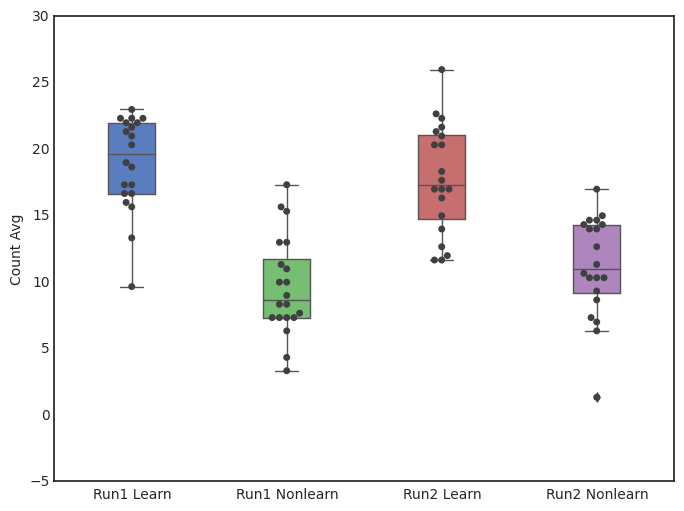

In [76]:
for key in avgs_df:
    print "Mean {0}: ".format(key), np.mean(avgs_df['{0}'.format(key)])
    print "STD {0}: ".format(key), np.std(avgs_df['{0}'.format(key)])
    print ""
print "Run 1 Learn vs. Nonlearn t-test: ", stats.ttest_rel(avgs_df['first_learn'], avgs_df['first_nonlearn'])[:]
print "Run 2 Learn vs. Nonlearn t-test: ", stats.ttest_rel(avgs_df['second_learn'], avgs_df['second_nonlearn'])[:]
N = 4
conditions = ['Run1 Learn', 'Run1 Nonlearn', 'Run2 Learn', 'Run2 Nonlearn']
allsubjs = [avgs_df['first_learn'], avgs_df['first_nonlearn'], 
            avgs_df['second_learn'], avgs_df['second_nonlearn']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (8,6))
ax0 = sns.boxplot(data = allsubjs, width = 0.3)
ax2 = sns.swarmplot(data = allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Count Avg")
plt.show()

Mean ratio_1st:  0.663120985833
STD ratio_1st:  0.125583651659

Mean ratio_2nd:  0.612893266196
STD ratio_2nd:  0.133950248882

Run 1 vs. Run 2 t-test:  (0.9963813899360493, 0.33158599462221217)


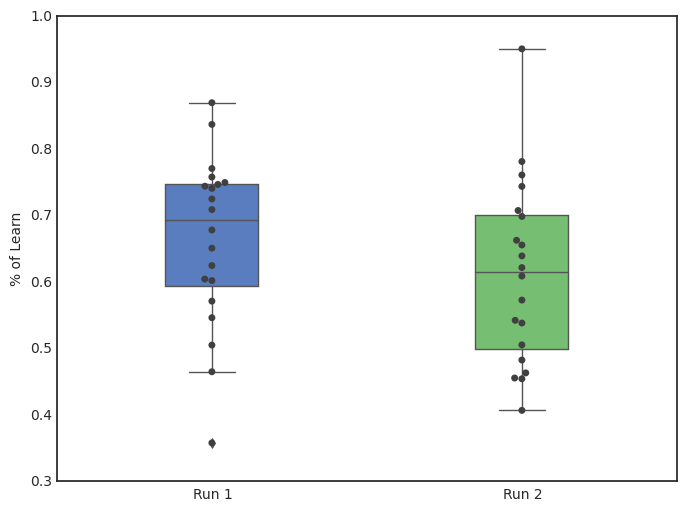

In [75]:
sns.set_style("white")
for x in ['ratio_1st', 'ratio_2nd']:
    print "Mean {0}: ".format(x), np.mean(avgs_df['{0}'.format(x)])
    print "STD {0}: ".format(x), np.std(avgs_df['{0}'.format(x)])
    print ""
print "Run 1 vs. Run 2 t-test: ", stats.ttest_rel(avgs_df['ratio_1st'], avgs_df['ratio_2nd'])[:]
N = 2
conditions = ['Run 1', 'Run 2']
allsubjs = [avgs_df['ratio_1st'], avgs_df['ratio_2nd']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (8,6))
ax0 = sns.boxplot(data = allsubjs, width = 0.3)
ax2 = sns.swarmplot(data = allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("% of Learn")
plt.show()